# Predicción de aprobación de préstamo

El objetivo de este proyecto es predecir si el préstamo sería aprobado por el banco, analizando la información del solicitante que incluye el monto del préstamo, la tenencia, el puntaje cibil, la educación, los activos y muchas otras variables. A través de este proyecto, podemos analizar los factores que afectan la aprobación del préstamo y también predecir el estado de aprobación del préstamo para un nuevo solicitante. Además, esto ayudará a brindar servicios prioritarios a los clientes que tienen más probabilidades de obtener la aprobación de su préstamo.

| Variable                  |        Significado                           | 
|---------------------------|----------------------------------------------|
| loan_id	                | ID                                           |
| no_of_dependent           | Número de dependientes del solicitante       |
| education	                | Nivel de educación del solicitante           |
| self_employed	            | Sí el solicitante es autónomo o no           |
| income_annum	            | Ingresos anuales del solicitante             |
| loan_amount               | Monto del préstamo solicitado                |
| loan_tenure	            | Tenencia del préstamo en años                |
| cibil_score               | Puntaje CIBIL del solicitante                |
| residential_asset_value   | Valor del activo residencial del solicitante |
| commercial_asset_value	| Valor del activo comercial del solicitante   |
| luxury_asset_value	    | Valor del activo de lujo del solicitante     |
| bank_assets_value	        | Valor del activo bancario del solicitante    |
| loan_status               | Estado del préstamo (Aprobado/Rechazado)     |

In [1]:
# importando librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

# Importando el dataset

In [2]:
# importando el dataset
df = pd.read_csv('loan_approval_dataset.csv')
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


# Procesamiento del dataset

In [3]:
# creando una nueva columna donde se suman los bienes muebles
df["Movable_assets"] = df[" bank_asset_value"] + df[" luxury_assets_value"]

In [4]:
# creando la columna donde se suman los bienes inmuebles
df["Immovable_assets"] = df[" residential_assets_value"] + df[" commercial_assets_value"]

In [5]:
# eliminando las columnas que no son relevantes
df.drop(columns=["loan_id", " bank_asset_value", " luxury_assets_value", " residential_assets_value", " commercial_assets_value"], inplace=True)

In [6]:
# chequeando si existen valores nulos
df.isnull().sum()

 no_of_dependents    0
 education           0
 self_employed       0
 income_annum        0
 loan_amount         0
 loan_term           0
 cibil_score         0
 loan_status         0
Movable_assets       0
Immovable_assets     0
dtype: int64

In [7]:
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Movable_assets,Immovable_assets
0,2,Graduate,No,9600000,29900000,12,778,Approved,30700000,20000000
1,0,Not Graduate,Yes,4100000,12200000,8,417,Rejected,12100000,4900000
2,3,Graduate,No,9100000,29700000,20,506,Rejected,46100000,11600000
3,3,Graduate,No,8200000,30700000,8,467,Rejected,31200000,21500000
4,5,Not Graduate,Yes,9800000,24200000,20,382,Rejected,34400000,20600000


# Análisis del dataset

In [8]:
print(f"Este dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas")

Este dataset contiene 4269 filas y 10 columnas


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0    no_of_dependents  4269 non-null   int64 
 1    education         4269 non-null   object
 2    self_employed     4269 non-null   object
 3    income_annum      4269 non-null   int64 
 4    loan_amount       4269 non-null   int64 
 5    loan_term         4269 non-null   int64 
 6    cibil_score       4269 non-null   int64 
 7    loan_status       4269 non-null   object
 8   Movable_assets     4269 non-null   int64 
 9   Immovable_assets   4269 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 333.6+ KB


In [10]:
# estadistica de la data numerica
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
no_of_dependents,4269.0,2.50,1.70,0.0,1.0,3.0,4.0,5.0
income_annum,4269.0,5059123.92,2806839.83,200000.0,2700000.0,5100000.0,7500000.0,9900000.0
loan_amount,4269.0,15133450.46,9043362.98,300000.0,7700000.0,14500000.0,21500000.0,39500000.0
loan_term,4269.0,10.90,5.71,2.0,6.0,10.0,16.0,20.0
cibil_score,4269.0,599.94,172.43,300.0,453.0,600.0,748.0,900.0
Movable_assets,4269.0,20102998.36,11836583.54,300000.0,10000000.0,19600000.0,29100000.0,53800000.0
Immovable_assets,4269.0,12445771.84,9232541.16,-100000.0,4900000.0,10600000.0,18200000.0,46600000.0


In [11]:
# estadistica de la data categorica
df.describe(include = "O").T

,count,unique,top,freq
education,4269,2,Graduate,2144
self_employed,4269,2,Yes,2150
loan_status,4269,2,Approved,2656


# Análisis Exploratorio de datos

En el análisis exploratorio de datos, observaré la distribución de los datos entre las variables, seguida de la relación entre la variable independiente y objetivo y la correlación entre las variables. A través de la visualización, podré comprender las posibles tendencias y patrones en los datos y conocer los conocimientos ocultos de los datos.

#### Número de dependientes

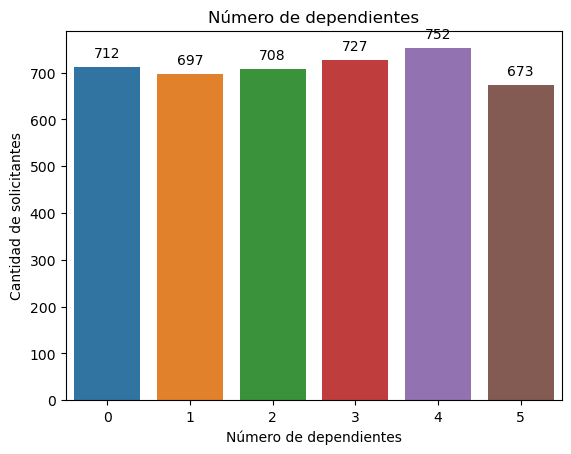

In [12]:
ax = sns.countplot(x= " no_of_dependents", data=df)
plt.title("Número de dependientes")
plt.xlabel("Número de dependientes")
plt.ylabel("Cantidad de solicitantes")

for valor in ax.patches:
    ax.annotate(f"{int(valor.get_height())}", 
                (valor.get_x() + valor.get_width() / 2., valor.get_height()),
                ha="center", va="center", xytext=(0, 10), textcoords="offset points")
    
plt.show()

Este gráfico muestra el número de personas dependientes del solicitante del préstamo. No hay mucha diferencia en el número de dependientes, sin embargo, hay más solicitantes con 4 y 3 dependientes que las otras categorías. Dado que el número de dependientes aumenta, la renta disponible del solicitante disminuye. Entonces se puede suponer que la cantidad de solicitantes con 0 o 1 dependientes tendrán mayores posibilidades de aprobación del préstamo.

#### Educación e Ingresos anuales

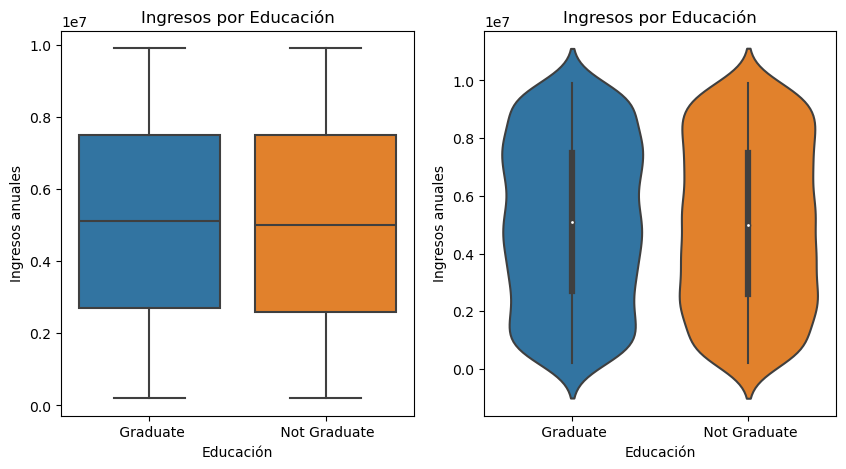

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x=" education", y=" income_annum", data=df, ax=ax[0]).set_title("Ingresos por Educación")
ax[0].set_xlabel("Educación")
ax[0].set_ylabel("Ingresos anuales")

sns.violinplot(x=" education", y=" income_annum", data=df, ax=ax[1]).set_title("Ingresos por Educación")
ax[1].set_xlabel("Educación")
ax[1].set_ylabel("Ingresos anuales")

plt.show()

Estos dos gráficos, diagrama de caja y diagrama de violín, visualizan la educación de los solicitantes junto con sus ingresos anuales. El diagrama de caja muestra un hecho interesante: tanto los graduados como los no graduados tienen casi el mismo ingreso medio con un aumento muy pequeño en el ingreso de los graduados. Además, el gráfico del violín muestra la distribución del ingreso entre los graduados y los solicitantes no graduados, donde podemos ver que los solicitantes no graduados tienen una distribución uniforme entre 2000000 y 8000000 de ingresos, mientras que hay una distribución desigual entre los graduados con más solicitantes con ingresos entre 6000000 y 8000000. Dado que no hay muchos cambios en los ingresos anuales de los graduados y no graduados, se puede suponer que la educación no juega un papel importante en la aprobación del préstamo.

#### Situación laboral y Educación

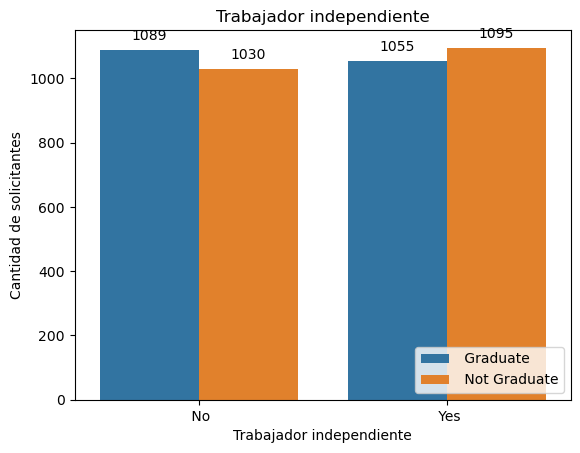

In [14]:
ax = sns.countplot(x=" self_employed", data = df, hue = " education")
plt.title("Trabajador independiente")
plt.xlabel("Trabajador independiente")
plt.ylabel("Cantidad de solicitantes")
plt.legend(loc="lower right")
for valor in ax.patches:
    ax.annotate(f"{int(valor.get_height())}", 
                (valor.get_x() + valor.get_width() / 2., valor.get_height()),
                ha="center", va="center", xytext=(0, 10), textcoords="offset points")
plt.show()

Este gráfico muestra el número de solicitantes que trabajan por cuenta propia junto con su educación. Desde el punto de vista educativo, la mayoría de los solicitantes graduados no trabajan por cuenta propia, mientras que la mayoría de los no graduados trabajan por cuenta propia. Esto significa que los solicitantes graduados tienen más probabilidades de ser empleados asalariados y los no graduados tienen más probabilidades de trabajar por cuenta propia. Esto podría ser un factor determinante en la aprobación del préstamo porque los empleados asalariados tienen más probabilidades de tener ingresos estables y, por lo tanto, más probabilidades de pagar el préstamo en comparación con los solicitantes que trabajan por cuenta propia cuyos ingresos pueden no ser estables. Pero también es posible que los solicitantes que trabajan por cuenta propia ganen más que los empleados asalariados y, por tanto, tengan más probabilidades de devolver el préstamo. Este es un factor muy importante a considerar al predecir la aprobación del préstamo.

#### Monto del préstamo y Tenencia 

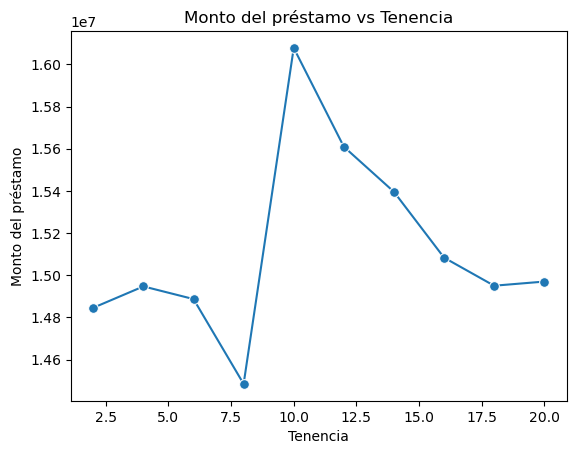

In [15]:
sns.lineplot(x = " loan_term", y = " loan_amount", data = df, ci=None, marker = "o", markersize = 7)
plt.title("Monto del préstamo vs Tenencia")
plt.xlabel("Tenencia")
plt.ylabel("Monto del préstamo")
plt.show()

Este gráfico de líneas muestra la tendencia entre el monto del préstamo y la duración del préstamo. Entre una duración del préstamo de 2,5 a 7,5 años, el monto del préstamo oscila entre 1400000 y 15500000. Sin embargo, el monto del préstamo es significativamente mayor para una duración del préstamo de 10 años.

#### Distribución del puntaje CIBIL

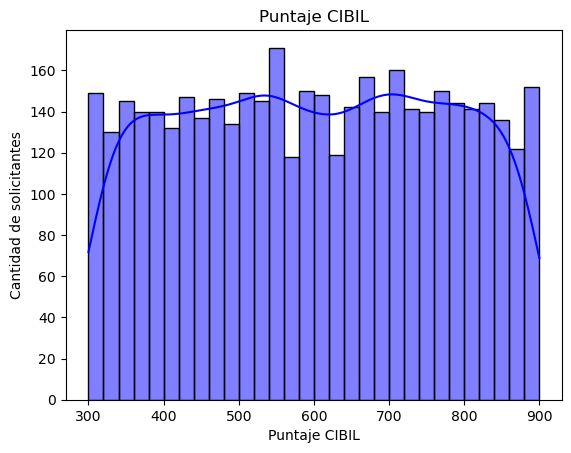

In [16]:
sns.histplot(df[" cibil_score"], bins = 30, kde = True, color = "blue")
plt.title("Puntaje CIBIL")
plt.xlabel("Puntaje CIBIL")
plt.ylabel("Cantidad de solicitantes")
plt.show()

Antes de mirar la puntuación CIBIL, echemos un vistazo a los rangos de puntuación CIBIL y su significado.

| Puntaje CIBIL             |        Significado       | 
|---------------------------|--------------------------|
| 300-549	                | Baja                     |
| 550-649                   | Regular                  |
| 650-749	                | Buena                    |
| 750-799	                | Muy buena                |
| 800-900	                | Excelente                |

Tomando la tabla anterior como referencia para la calidad del puntaje CIBIL, la mayoría de los clientes tienen un puntaje CIBIL inferior a 649, lo que afecta su solicitud de préstamo. Sin embargo, hay muchos solicitantes con una puntuación CIBIL superior a 649, lo que es una buena señal para el banco. El banco puede dirigirse a estos clientes y ofrecerles servicios prioritarios. El banco también puede ofrecerles ofertas especiales y descuentos para atraerlos a solicitar préstamos del banco. A partir de esto, construyo la hipótesis de que los clientes con una puntuación CIBIL superior a 649 tienen más probabilidades de obtener la aprobación de su préstamo.

#### Distribución de activos

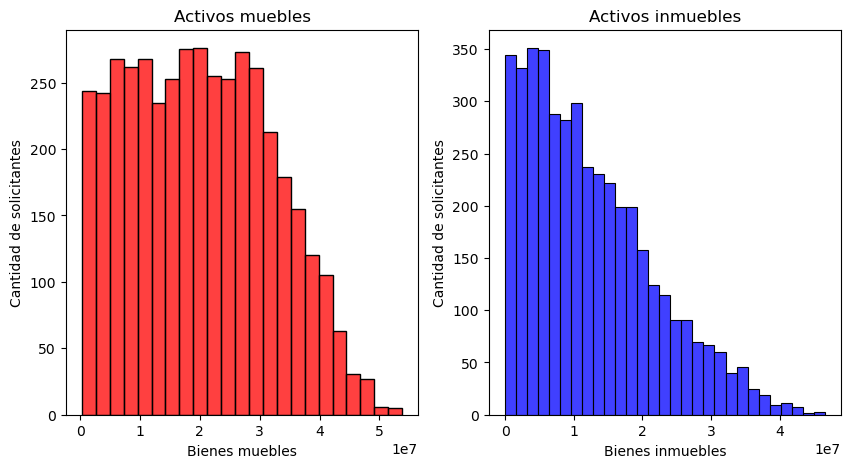

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(df["Movable_assets"], ax=ax[0], color="red").set_title("Activos muebles")
ax[0].set_xlabel("Bienes muebles")
ax[0].set_ylabel("Cantidad de solicitantes")

sns.histplot(df["Immovable_assets"], ax=ax[1], color="blue").set_title("Activos inmuebles")
ax[1].set_xlabel("Bienes inmuebles")
ax[1].set_ylabel("Cantidad de solicitantes")

plt.show()

Los activos juegan un papel importante en la solicitud de préstamo. Proporcionan una seguridad al banco de que la persona pagará el préstamo. En cuanto a los activos, como ya he mencionado, los he clasificado en bienes muebles e inmuebles. Los gráficos anteriores muestran la distribución de activos muebles e inmuebles en el conjunto de datos.

En cuanto a los activos muebles, que incluyen activos bancarios y activos de lujo, la mayoría de los solicitantes tienen menos de 30 millones y hay una ligera tendencia a disminuir el número de solicitantes a medida que aumentan los activos muebles. En cuanto a los activos inmobiliarios, que incluyen activos residenciales y activos comerciales, la mayoría de los solicitantes tienen menos de 15 millones de activos inmobiliarios y hay una fuerte tendencia a disminuir el número de solicitantes a medida que los activos inmobiliarios aumentan después de los 20 millones.

Hasta ahora, en el Análisis Exploratorio de Datos, he explorado la distribución de datos entre las diversas características, así como la relación entre algunas de las variables, y he hecho algunas suposiciones e hipótesis. Ahora, para probar mis suposiciones e hipótesis, observaré la visualización de la relación entre las variables independientes y la variable objetivo.

#### Número de dependientes vs Estado del préstamo

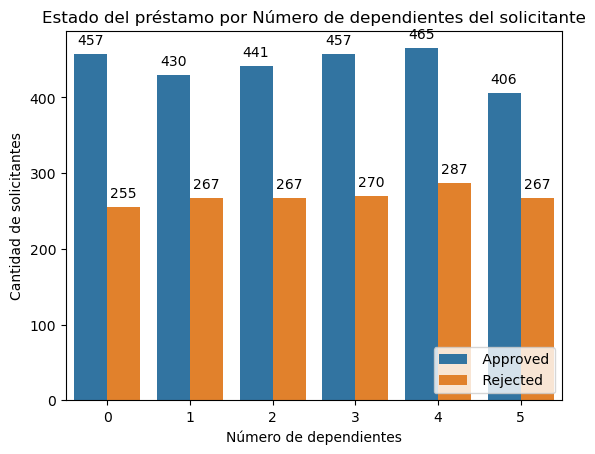

In [18]:
ax = sns.countplot(x = " no_of_dependents", data = df, hue = " loan_status")
plt.title("Estado del préstamo por Número de dependientes del solicitante")
plt.xlabel("Número de dependientes")
plt.ylabel("Cantidad de solicitantes")
plt.legend(loc="lower right")
for valor in ax.patches:
    ax.annotate(f"{int(valor.get_height())}", 
                (valor.get_x() + valor.get_width() / 2., valor.get_height()),
                ha="center", va="center", xytext=(0, 10), textcoords="offset points")
plt.show()

Mi hipótesis sobre la aprobación del préstamo en función del número de dependientes tiene resultados mixtos. En primer lugar, la hipótesis era algo cierta con respecto a las posibilidades de rechazo: el número de rechazos de préstamos aumenta con el aumento del número de dependientes. Pero la hipótesis no era cierta con respecto a las posibilidades de aprobación, según mi hipótesis, el número de aprobación de préstamos disminuye con el aumento en el número de dependientes. Pero según este gráfico, no ha habido cambios importantes en el recuento de aprobación de préstamos con un aumento en el número de dependientes. Entonces, mi hipótesis sobre la aprobación del préstamo en función del número de dependientes no es cierta.

#### Educación vs Estado del préstamo

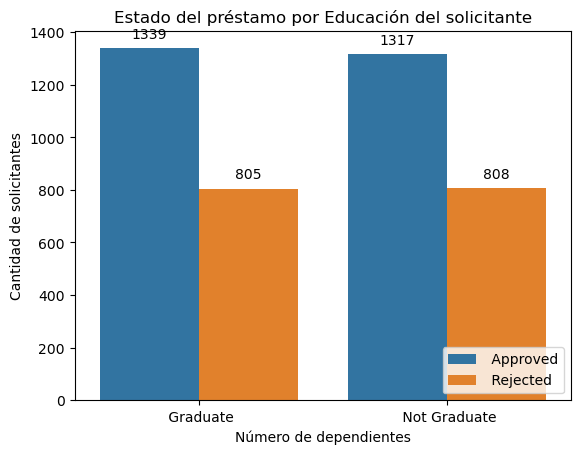

In [19]:
ax = sns.countplot(x = " education", data = df, hue = " loan_status")
plt.title("Estado del préstamo por Educación del solicitante")
plt.xlabel("Número de dependientes")
plt.ylabel("Cantidad de solicitantes")
plt.legend(loc="lower right")
for valor in ax.patches:
    ax.annotate(f"{int(valor.get_height())}", 
                (valor.get_x() + valor.get_width() / 2., valor.get_height()),
                ha="center", va="center", xytext=(0, 10), textcoords="offset points")
plt.show()

Mi hipótesis acerca de que la educación no influye en la aprobación del préstamo era correcta. El gráfico muestra una diferencia muy pequeña entre el recuento de aprobación y rechazo de préstamos para solicitantes graduados y no graduados. La diferencia no es lo suficientemente significativa.

#### Ingreso anual vs Estado del préstamo

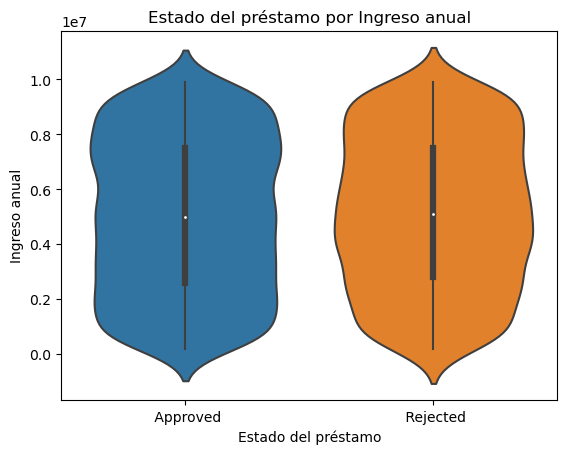

In [20]:
sns.violinplot(x=" loan_status", y=" income_annum", data=df)
plt.title("Estado del préstamo por Ingreso anual")
plt.xlabel("Estado del préstamo")
plt.ylabel("Ingreso anual")
plt.show()

En general, no ha habido ninguna diferencia importante entre los ingresos anuales del solicitante con préstamo aprobado o rechazado. Pero aún así, los solicitantes de préstamos aprobados tienden a tener un ingreso anual más alto que los solicitantes de préstamos rechazados, lo cual es visible en el gráfico del violín donde los solicitantes de préstamos aprobados tienen una mayor densidad en el ingreso anual, cerca de 8 millones de ingresos anuales.

#### Monto del préstamo y Tenencia vs Estado del préstamo

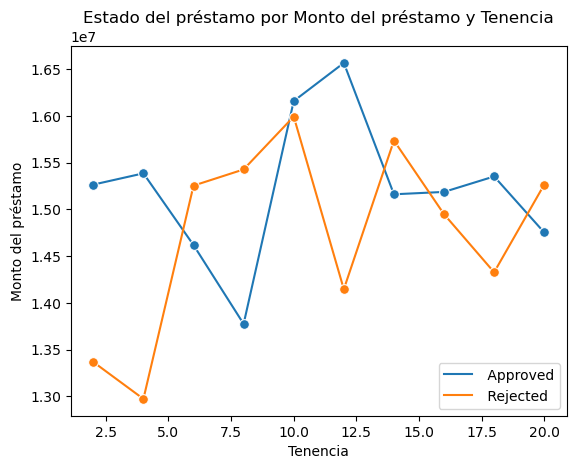

In [21]:
sns.lineplot(x=" loan_term", y=" loan_amount", data=df, hue=" loan_status", marker = "o", markersize = 7, ci=None)
plt.title("Estado del préstamo por Monto del préstamo y Tenencia")
plt.xlabel("Tenencia")
plt.ylabel("Monto del préstamo")
plt.legend(loc="lower right")
plt.show()

Este gráfico muestra la relación entre el monto del préstamo, la duración del préstamo y el estado del préstamo. Generalmente, los préstamos aprobados tienden a tener un monto mayor y un plazo de amortización más corto. Los préstamos rechazados tienden a tener un monto menor y un plazo de amortización más largo. Esto podría ser el resultado de la política del banco de rechazar préstamos con plazos de amortización más largos. El banco también puede rechazar préstamos de importe inferior, ya que pueden no ser rentables para el banco.

#### Puntaje CIBIL vs Estado del préstamo

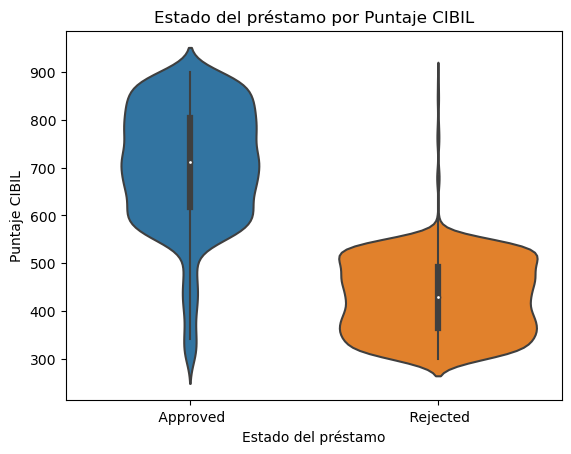

In [22]:
sns.violinplot(x=" loan_status", y=" cibil_score", data=df)
plt.title("Estado del préstamo por Puntaje CIBIL")
plt.xlabel("Estado del préstamo")
plt.ylabel("Puntaje CIBIL")
plt.show()

Mi hipótesis sobre la puntuación CIBIL y la aprobación del préstamo es absolutamente correcta. Es evidente a través del gráfico del violín, donde hay una alta distribución por encima de 600 puntos CIBIL de la categoría de préstamo aprobado. La distribución de la categoría de préstamo no aprobado está más dispersa y tiene una puntuación CIBIL inferior a 550. Esto también prueba mi suposición de que la mayoría de los solicitantes tienen una puntuación CIBIL baja/regular, lo que afecta la aprobación de su préstamo. Por lo tanto, tener una puntuación CIBIL alta, particularmente superior a 600, definitivamente aumentaría las posibilidades de aprobación del préstamo.

#### Activos vs Estado del préstamo

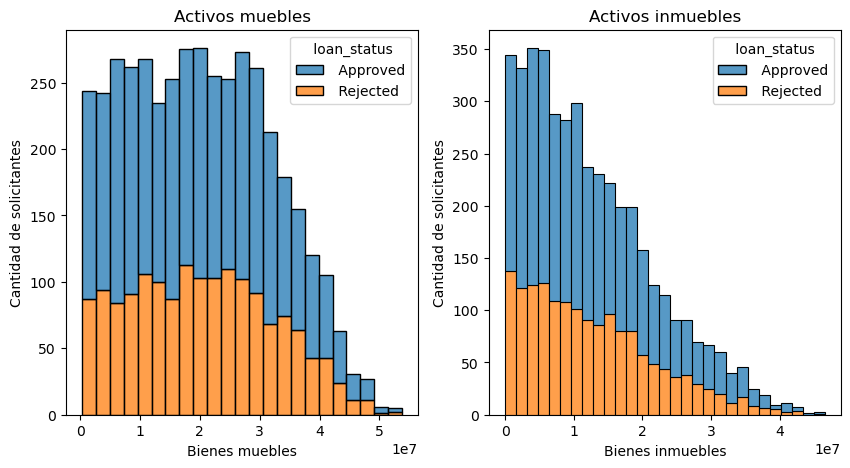

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.histplot(x  = "Movable_assets", data = df, ax=ax[0], hue = " loan_status", multiple="stack").set_title("Activos muebles")
ax[0].set_xlabel("Bienes muebles")
ax[0].set_ylabel("Cantidad de solicitantes")

sns.histplot(x =  "Immovable_assets", data = df, ax=ax[1], hue  = " loan_status", multiple="stack").set_title("Activos inmuebles")
ax[1].set_xlabel("Bienes inmuebles")
ax[1].set_ylabel("Cantidad de solicitantes")

plt.show()

Los activos brindan seguridad al banco contra el cual se emite el préstamo. Estos dos gráficos visualizan la relación entre los activos muebles e inmuebles junto con el estado del préstamo. Ambos gráficos muestran que, con el aumento de los activos, aumentan las posibilidades de aprobación del préstamo y disminuyen el rechazo. El gráfico también muestra que los bienes muebles son más que los bienes inmuebles.

# Conversión de variables categóricas a numéricas

In [24]:
df[" education"] = df[" education"].map({" Not Graduate":0 ," Graduate":1})
df[" self_employed"] = df[" self_employed"].map({" No":0 , " Yes":1})
df[" loan_status"] = df[" loan_status"].map({" Rejected":0 , " Approved":1})
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Movable_assets,Immovable_assets
0,2,1,0,9600000,29900000,12,778,1,30700000,20000000
1,0,0,1,4100000,12200000,8,417,0,12100000,4900000
2,3,1,0,9100000,29700000,20,506,0,46100000,11600000
3,3,1,0,8200000,30700000,8,467,0,31200000,21500000
4,5,0,1,9800000,24200000,20,382,0,34400000,20600000


# Mapa de calor

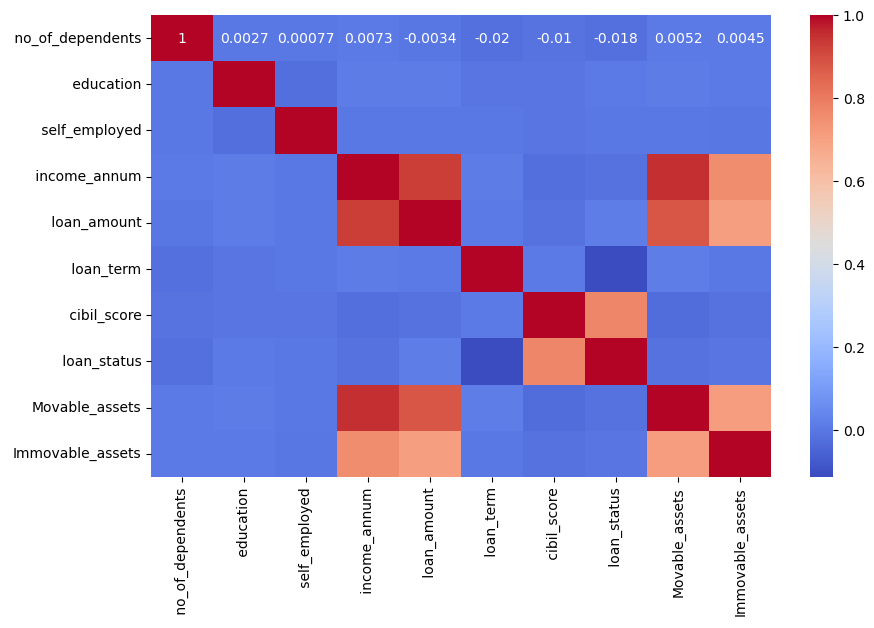

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot = True,cmap="coolwarm")
plt.show()

Este mapa de calor de matriz de correlación tiene las siguientes fuertes correlaciones:

1. Bienes muebles y bienes inmuebles.
2. Ingresos anuales y Bienes muebles.
3. Ingresos anuales y Bienes inmuebles.
4. Bienes muebles y monto del préstamo.
5. Bienes inmuebles y monto del préstamo.
6. Estado del préstamo y puntuación CIBIL.
7. Monto del préstamo e ingresos anuales.

La correlación entre bienes muebles e inmuebles se justifica porque ambos pertenecen a la categoría de activos y es obvio que la persona con más bienes muebles tendrá más bienes inmuebles y viceversa. Lo mismo ocurre con los ingresos anuales y los bienes muebles e inmuebles. La persona con mayores ingresos tendrá mayores activos.

Ahora, exploraré la correlación entre activos y monto del préstamo, y también entre ingresos y monto del préstamo. La relación entre el estado del préstamo y la puntuación CIBIL ya se explora en la sección anterior.

#### Activos vs Monto del préstamo

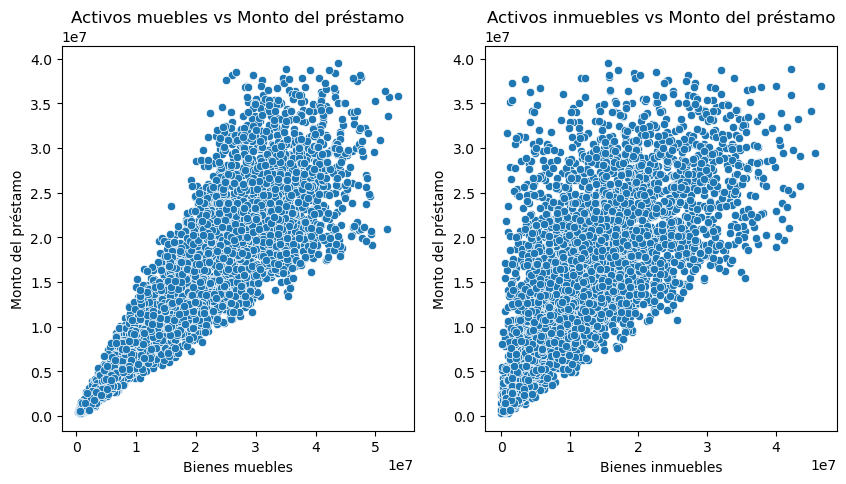

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x="Movable_assets", y = " loan_amount", data = df, ax=ax[0]).set_title("Activos muebles vs Monto del préstamo")
ax[0].set_xlabel("Bienes muebles")
ax[0].set_ylabel("Monto del préstamo")

sns.scatterplot(x="Immovable_assets", y = " loan_amount", data = df, ax=ax[1]).set_title("Activos inmuebles vs Monto del préstamo")
ax[1].set_xlabel("Bienes inmuebles")
ax[1].set_ylabel("Monto del préstamo")

plt.show()

El monto del préstamo tiene una relación positiva con los bienes muebles e inmuebles. Cuanto mayores sean los activos, mayor será el monto del préstamo emitido por el banco.

#### Monto del préstamo vs Ingresos anuales

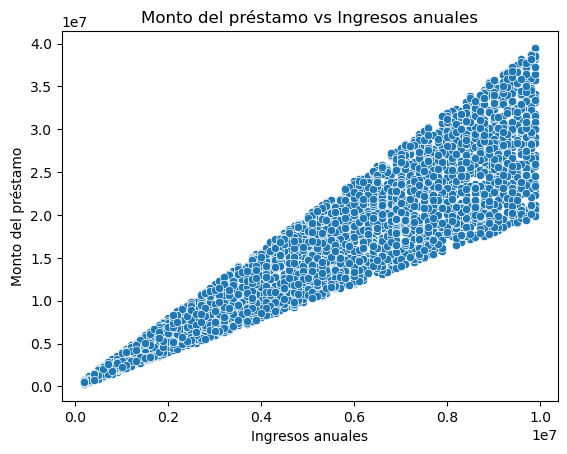

In [27]:
sns.scatterplot(x=" income_annum", y = " loan_amount", data = df)
plt.title("Monto del préstamo vs Ingresos anuales")
plt.xlabel("Ingresos anuales")
plt.ylabel("Monto del préstamo")
plt.show()

El monto del préstamo y los ingresos anuales del solicitante tienen una relación muy directa entre ellos. Cuanto mayores sean los ingresos, mayor será el monto del préstamo. Esto se debe a que los ingresos del solicitante son el factor principal a la hora de decidir cuánto préstamo necesita.

# Train Test Split

In [28]:
X = df.drop(" loan_status", axis=1)
Y = df[" loan_status"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Construcción del modelo

Usaré los siguientes modelos de aprendizaje automático para predecir el estado de aprobación del préstamo:
- Decision Tree Classifier
- Random Forest Classifier

# Decision Tree Classifier

In [29]:
dtree = DecisionTreeClassifier()
param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4],
    "random_state": [0, 42]
}

# desarrollando un grid search con validación cruzada para encontrar los mejores hiperparametros
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}


In [30]:
dtree = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_leaf=1, min_samples_split=2)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [31]:
dtree.score(X_train, y_train)

0.9915080527086384

# Evaluación del modelo

In [32]:
dtree_pred = dtree.predict(X_test)

In [33]:
print("Accuracy Score : ", accuracy_score(y_test, dtree_pred).round(2))
print("F-1 Score : ", f1_score(y_test, dtree_pred).round(2))
print("Precision Score : ", precision_score(y_test, dtree_pred).round(2))
print("Recall Score : ", recall_score(y_test, dtree_pred).round(2))
print("Jaccard Score : ", jaccard_score(y_test, dtree_pred).round(2))
print("Log Loss : ", log_loss(y_test, dtree_pred).round(2))

Accuracy Score :  0.97
F-1 Score :  0.98
Precision Score :  0.97
Recall Score :  0.99
Jaccard Score :  0.95
Log Loss :  1.1


#### Características más importantes para el modelo

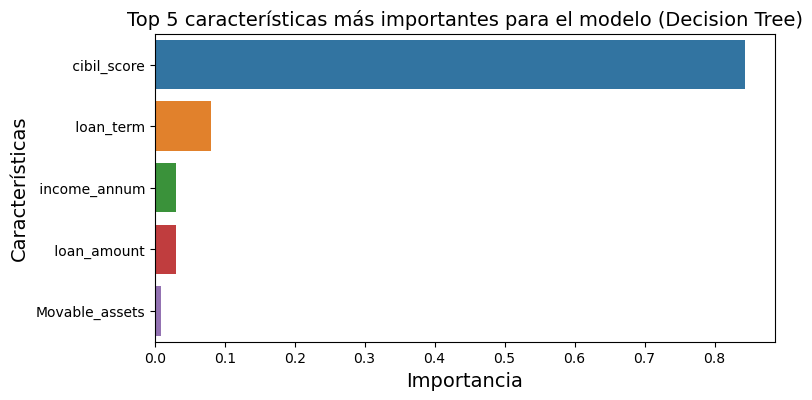

In [34]:
dtree_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": dtree.feature_importances_
})
fi = dtree_df.sort_values(by="Importancia", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(8,4))
sns.barplot(data=fi2, x="Importancia", y="Variable")
plt.title("Top 5 características más importantes para el modelo (Decision Tree)", fontsize=14)
plt.xlabel ("Importancia", fontsize=14)
plt.ylabel ("Características", fontsize=14)
plt.show()

#### Matriz de confusión

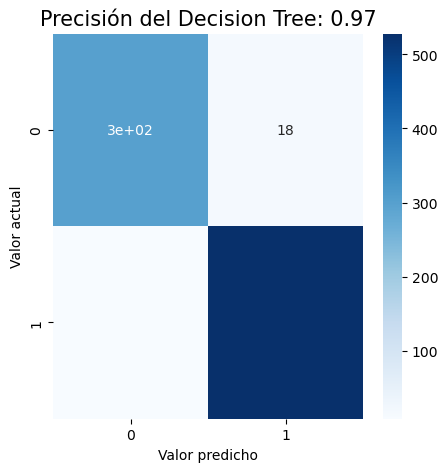

array([[300,  18],
       [  8, 528]], dtype=int64)

In [48]:
cm_dtree = confusion_matrix(y_test, dtree_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm_dtree, annot=True,  cmap = "Blues")
plt.ylabel("Valor actual")
plt.xlabel("Valor predicho")
all_sample_title = "Precisión del Decision Tree: {0}".format((accuracy_score(y_test, dtree_pred)).round(2))
plt.title(all_sample_title, size = 15)
plt.show()
confusion_matrix(y_test, dtree_pred)

#### Curva ROC y AUC

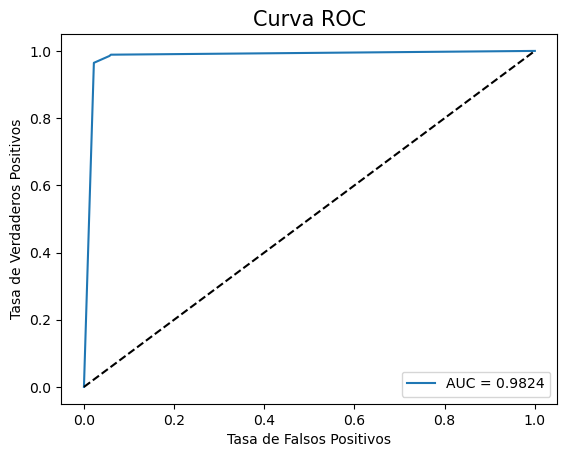

In [36]:
y_pred_proba = dtree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"]), pd.DataFrame(y_pred_proba, columns=["y_pred_proba"])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted["y_actual"], df_actual_predicted["y_pred_proba"])
auc = roc_auc_score(df_actual_predicted["y_actual"], df_actual_predicted["y_pred_proba"])

plt.plot(fpr, tpr, label="AUC = %0.4f" %auc)
plt.plot(fpr, fpr, linestyle = "--", color="k")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC", size = 15)
plt.legend()
plt.show()

# Random Forest Classifier

In [37]:
rfc = RandomForestClassifier()
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "max_features": ["sqrt", "log2", None],
    "random_state": [0, 42]
}

# desarrollando un grid search con validación cruzada para encontrar los mejores hiperparametros
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': None, 'max_features': None, 'n_estimators': 200, 'random_state': 42}


In [38]:
rfc = RandomForestClassifier(random_state=42, max_depth=None, max_features=None, n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=None, n_estimators=200, random_state=42)

In [39]:
rfc.score(X_train, y_train)

1.0

# Evaluación del modelo

In [40]:
rfc_pred = rfc.predict(X_test)

In [41]:
print("Accuracy Score : ", accuracy_score(y_test, rfc_pred).round(2))
print("F-1 Score : ", f1_score(y_test, rfc_pred).round(2))
print("Precision Score : ", precision_score(y_test, rfc_pred).round(2))
print("Recall Score : ", recall_score(y_test, rfc_pred).round(2))
print("Jaccard Score : ", jaccard_score(y_test, rfc_pred).round(2))
print("Log Loss : ", log_loss(y_test, rfc_pred).round(2))

Accuracy Score :  0.98
F-1 Score :  0.99
Precision Score :  0.98
Recall Score :  0.99
Jaccard Score :  0.97
Log Loss :  0.68


#### Características más importantes para el modelo

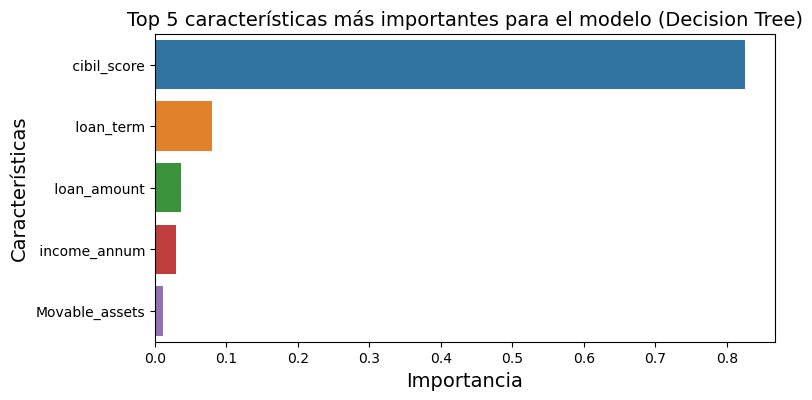

In [49]:
rfc_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": rfc.feature_importances_
})
fi = rfc_df.sort_values(by="Importancia", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(8,4))
sns.barplot(data=fi2, x="Importancia", y="Variable")
plt.title("Top 5 características más importantes para el modelo (Decision Tree)", fontsize=14)
plt.xlabel ("Importancia", fontsize=14)
plt.ylabel ("Características", fontsize=14)
plt.show()

#### Matriz de confusión

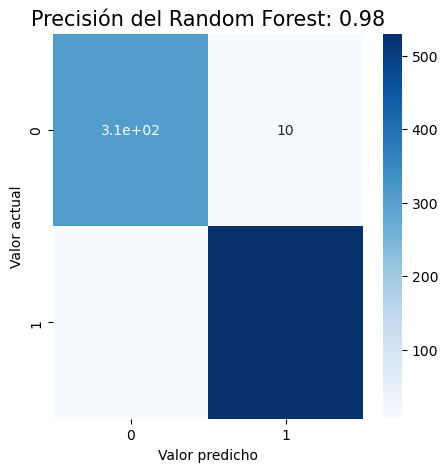

array([[308,  10],
       [  6, 530]], dtype=int64)

In [50]:
cm_rfc = confusion_matrix(y_test, rfc_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm_rfc, annot=True,  cmap = "Blues")
plt.ylabel("Valor actual")
plt.xlabel("Valor predicho")
all_sample_title = "Precisión del Random Forest: {0}".format((accuracy_score(y_test, rfc_pred)).round(2))
plt.title(all_sample_title, size = 15)
plt.show()
confusion_matrix(y_test, rfc_pred)

#### Curva ROC y AUC

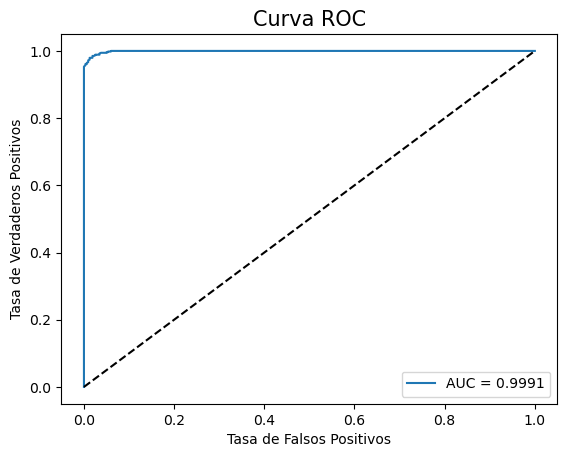

In [51]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"]), pd.DataFrame(y_pred_proba, columns=["y_pred_proba"])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted["y_actual"], df_actual_predicted["y_pred_proba"])
auc = roc_auc_score(df_actual_predicted["y_actual"], df_actual_predicted["y_pred_proba"])

plt.plot(fpr, tpr, label="AUC = %0.4f" %auc)
plt.plot(fpr, fpr, linestyle = "--", color="k")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC", size = 15)
plt.legend()
plt.show()

# Conclusión

Del análisis de datos exploratorios, podemos concluir que los siguientes factores son importantes para la aprobación del préstamo:

- Puntaje CIBIL: las personas con puntaje CIBIL más alto tienen mayores posibilidades de aprobación del préstamo.
- Número de dependientes: las personas con mayor número de dependientes tienen menos posibilidades de aprobación del préstamo.
- Activos: las personas con más activos (incluidos muebles e inmuebles) tienen mayores posibilidades de aprobación del préstamo.
- Monto y duración del préstamo: las personas con un monto de préstamo más alto y una duración más baja tienen más posibilidades de aprobación del préstamo.

En cuanto a los modelos, de todas las métricas, gráficos e informes anteriores, concluyo que el Random Forest es el mejor modelo de aprendizaje automático para predecir el estado de aprobación de un préstamo de una persona y esto debido a su buena precisión en la predicción y por su baja tasa de predicciones erróneas, es decir, posee una baja tasa de Falsos Positivos y Falsos Negativos.

# Sistema de predicción

In [52]:
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Movable_assets,Immovable_assets
0,2,1,0,9600000,29900000,12,778,1,30700000,20000000
1,0,0,1,4100000,12200000,8,417,0,12100000,4900000
2,3,1,0,9100000,29700000,20,506,0,46100000,11600000
3,3,1,0,8200000,30700000,8,467,0,31200000,21500000
4,5,0,1,9800000,24200000,20,382,0,34400000,20600000


In [54]:
def prediccion_prestamo (data):
    input_data_as_numpy_array= np.asarray(data)

    input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

    prediction = rfc.predict(input_data_reshaped)
    
    print(f'El resultado es {prediction[0]}')

    if (prediction[0]== 0):
      print("Préstamo rechazado")
    else:
      print("Préstamo aprobado")

In [55]:
datos_prediccion = (2,1,0,9600000,29900000,12,778, 30700000, 20000000) # prestamo aprobado
prediccion_prestamo(datos_prediccion)

El resultado es 1
Préstamo aprobado


In [56]:
datos_prediccion = (0,0,1,4100000,12200000,8,417,12100000,4900000) # prestamo rechazado
prediccion_prestamo(datos_prediccion)

El resultado es 0
Préstamo rechazado
